In [29]:
#INITIALIZATIONS

import numpy as np;
import _thread
import pygame
from random import random
import mido as mido;
import seaborn as sns
import matplotlib.image as img
import matplotlib.pyplot as plt;
import matplotlib as mpl

from mido import Message, MidiFile, MidiTrack
from mido import MidiFile;
from scipy.interpolate import griddata
from random import choice

%matplotlib inline
mpl.rc('xtick', direction='in',top=True)
mpl.rc('ytick', direction='in',right=True)

from ipywidgets import IntProgress
from IPython.display import display
from IPython.display import display

# Modeling Rhythm as an Ordered Phase
#### Robert St.Clair

-----
This notebook contians code written for my capstone paper, *Exploring Characteristics of Rhythm Structure Using Statistical Mechanics*. This notebook is a rough walkthrough of the methods I used to obtain the data and figures in my paper. 

## The Phase Diagram

The first few methods I wrote solve for the $p_l$ values of our time bin probability chain. `computeProbDist` computes these probabilites over a range of $\mu$ values at a constant $T$, while `plotProbs` computes only the probabilites for a specific pair of $T$ and $\mu$ and displayes and returns these probabilities. 

`calcDist` calculates the note length distribution from a given rhythm, which is used in plotting fiunction `plotNoteDist` as well as functions that obtain the note length distribution of known compositions.

In [63]:
def computeProbDist(mu_bounds,mu_spacing,T,l0,image=False):
    ps = np.empty(l0);
    #T = 1.25;
    muax = np.arange(mu_bounds[0],mu_bounds[1]+mu_spacing,mu_spacing);
    #l0 = 8;  #number of sites

    for mu in muax:

        #p=rand(1,l0);  %generally still works to solve with random initial
        #condition, but sometimes messes up
        p=np.array([.9, .1, .3, .1, .5, .1, .3, .1, .75, .1, .3, .1, .5, .1, .3, .1, .5, .1]);  #2s
        #p=np.array([.9, .1, .1, .6, .1, .1, .76, .1, .1, .8, .1, .1, .6, .1, .1, .6, .1, .1]);  #3s
        #p=np.random.rand(18) #rand
        p=p[:l0]
        deltar = np.zeros(l0);
        newp = np.zeros(l0);

        for kk in range(0,800):
            for n in range(0,l0):
                dr=0;
                for ii in range(0,l0):

                    dr = dr + p[(n+ii)%l0]*p[(n-ii)%l0] + 2*p[(n+ii)%l0]*p[(n+2*ii)%l0]; 

                dr = dr*l0/(sum(p)**2);
                deltar[n] = dr;

            for ii in range (0,l0):
                newp[ii] = 1/(1+np.exp(-1*(deltar[ii]+mu)/T));


            p = .5*newp+.5*p;

        maxind = np.argmax(p)
        pshft = np.roll(p,-maxind)
        ps = np.vstack([ps,pshft])

    ps = ps[1::]

    if image==True:
        plt.imshow(ps,aspect=1/2,origin='lower',extent=[1,l0,mu_bounds[0],mu_bounds[1]],interpolation='none',cmap="Greys")
        plt.xlabel("Time Bin Probability Site")
        plt.ylabel("μ")
    
    return ps

def plotProbs(T,mu,l0,display=True,bias = 2):

    #T,mu = 1.00,-4.0
    #l0 = 8

    prob = np.empty(l0);

    #p=rand(1,l0);  %generally still works to solve with random initial
    #condition, but sometimes messes up
    if bias == 2:
        p=np.array([.9, .1, .3, .1, .5, .1, .3, .1, .75, .1, .3, .1, .5, .1, .3, .1, .5, .1]);  #2s
    elif bias == 3:
        p=np.array([.9, .1, .1, .6, .1, .1, .76, .1, .1, .8, .1, .1, .6, .1, .1, .6, .1, .1]);  #3s
    else:
        p=np.random.rand(l0) #rand
    p=p[:l0]
    deltar = np.zeros(l0);
    newp = np.zeros(l0);

    for kk in range(0,800):
        for n in range(0,l0):
            dr=0;
            for ii in range(0,l0):

                dr = dr + p[(n+ii)%l0]*p[(n-ii)%l0] + 2*p[(n+ii)%l0]*p[(n+2*ii)%l0]; 

            dr = dr*l0/(sum(p)**2);
            deltar[n] = dr;

        for ii in range (0,l0):
            newp[ii] = 1/(1+np.exp(-1*(deltar[ii]+mu)/T));


        p = .5*newp+.5*p;

    maxind = np.argmax(p)
    pshft = np.roll(p,-maxind)
    if (display):
        plt.bar(range(0,l0),pshft,width=.5)
        plt.title("T: "+str(T)+" Mu: "+str(mu),size=15);
        plt.xlabel("Time Bin",size=14)
        plt.ylabel("Probability",size=14)
        plt.ylim([0,1])
        
    delR = sum(deltar)/l0
    
    return pshft, delR


def calcDist(rhythm,l0,lim):
    notelengths = np.zeros(lim*10)
    note = False;
    length = 0;
    for site in rhythm:
        if site == 1:
            if note:
                if (length <= lim*10-1):
                    notelengths[length] += 1
            note = True;
            length = 1;
        elif note:
            length += 1;
    
    return notelengths[0:lim]/sum(notelengths)

def plotNoteDist(T,mu,l0,nbars,lim=16,probs=True):
    if probs:
        plt.subplot(1,2,1)
    p,R = plotProbs(T, mu, l0, display=probs)
    random = np.random.rand(l0*nbars)
    rhyth = np.tile(p,nbars);
    sample_vec = np.zeros(l0*nbars)
    for i in range(len(rhyth)):
        if random[i] < rhyth[i]:
            sample_vec[i] = 1;
    
    probab = calcDist(sample_vec,l0,lim)
    if probs:
        plt.subplot(1,2,2)
    plt.bar(range(0,lim),probab[0:lim],width=0.25)
    plt.xlim([0,lim])
    plt.ylim([0,1])
    plt.title("Note Length Probabilities");
    plt.xlabel("Note Length",size=14)
    plt.ylabel("Probability")
    
    return probab[0:lim]

def seperateProbDist(mu_bounds,mu_spacing,T,l0,iters,correction=True):
    prob = computeProbDist(mu_bounds,mu_spacing,T,l0,image=False);

    p1 = np.zeros((len(prob),len(prob[0])))
    p2 = np.zeros((len(prob),len(prob[0])))
    p3 = np.zeros((len(prob),len(prob[0])))

    for i in range(iters):
        for x in range(len(prob)):
            if np.round(prob[x][1]/prob[x][0],2) == 1:
                p1[x] = prob[x]
            elif np.round(prob[x][2]/prob[x][0],2) == 1:
                p2[x] = prob[x]
            else:
                p3[x] = prob[x]
        if i != iters - 1:
            prob = computeProbDist(mu_bounds,mu_spacing,T,l0,image=False);

    if correction:
        for x in range(len(p1)):
            if sum(p2[x]) == 0:
                p2[x] = p1[x]
            if sum(p3[x]) == 0:
                p3[x] = p2[x]
            
    plt.figure()
    plt.imshow(p1,aspect=1/2,origin='lower',extent=[1,l0,mu_bounds[0],mu_bounds[1]],interpolation='none')
    plt.figure()
    plt.imshow(p2,aspect=1/2,origin='lower',extent=[1,l0,mu_bounds[0],mu_bounds[1]],interpolation='none')
    plt.figure()
    plt.imshow(p3,aspect=1/2,origin='lower',extent=[1,l0,mu_bounds[0],mu_bounds[1]],interpolation='none')
    
    return p1,p2,p3

Using these functions, we are able to visualize our model at different $T$ and $\mu$. The first plot visualizes probabilites at different sites and different values of $\mu$ with probabilites of 0 and 1 represented by black and white, respectively. The second plot shows the probabilites at a particular pair of $T$ and $\mu$.

Text(0.5, 1.0, 'T = 1.0, μ = -6.0')

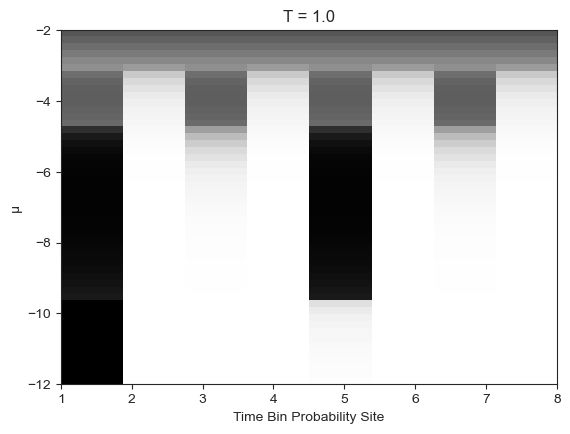

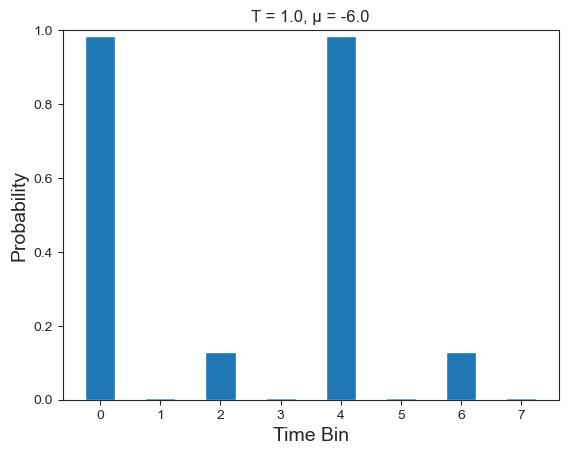

In [920]:
#p1,p2,p3 = seperateProbDist([-12.0,-1],0.1,1.0,6,20,correction=True)
plt.figure();
computeProbDist([-12.0,-2],0.2,1.0,8,image=True);
plt.title("T = 1.0")
plt.figure()
plotProbs(1.0,-6,8,display=True)
plt.title("T = 1.0, μ = -6.0")

I then wrote a method to plot a phase diagram by iterating the `computeProbDist` method over $T$, storing the $p_l$ values at each point. I then used these values to describe the periodicity of our time bin probability chain, where the ratio between the first peak and other certian key peaks tells us about how many times the probability pattern repeats itself within a single link of our chain.

In [4]:
def plotPhaseDiagram(T_range,T_spacing,mu_range,mu_spacing,l0,pattern=2,xdiv=9,ydiv=11):
    
    min_mu = mu_range[0]
    max_mu = mu_range[1]
    min_temp = T_range[0]
    max_temp = T_range[1]
    
    rem = pattern % 2

    temps = []
    RGBs = []
    mus = []

    temps_range = np.arange(min_temp,max_temp+T_spacing,T_spacing)
    
    f = IntProgress(min=0, max=len(temps_range), style={'bar_color': 'green'})
    display(f)

    for temperature in temps_range:

        mu_vec = np.arange(min_mu,max_mu+mu_spacing,mu_spacing)
        Cv = np.zeros((len(mu_vec),3))

        T_vec = temperature*np.ones(len(mu_vec))

        ps = computeProbDist([min_mu,max_mu],mu_spacing,temperature,l0)

        for index in range(len(mu_vec)):

            #RED: ratio between max probability and the peak at position 1/2
            R = ps[index][0]/ps[index][int(l0/(pattern) + rem)]
            G = 0
            B = 0

            if l0 > pattern:
                #GREEN: ratio between max probability and the peak at position 1/4
                G = ps[index][0]/ps[index][int(l0/(pattern*2) + rem)]

                if l0 > pattern*2:
                    #BLUE: ratio between max probability and the peak at position 1/8
                    B = ps[index][0]/ps[index][int(l0/(pattern*4) + rem)]


            Cv[index] = [R,G,B]
            

        temps = np.append(temps,T_vec)
        RGBs = np.append(RGBs,Cv)
        mus = np.append(mus,mu_vec)
        
        f.value += 1

    for x in range(0,len(RGBs)):
        if RGBs[x] > 1:
            RGBs[x] = 1/RGBs[x]

    RGB_vals = np.array(RGBs).reshape((int(len(RGBs)/3),3))
    
    A,B = int(len(RGB_vals)/len(temps_range)),len(temps_range)

    sns.set_style("ticks")
    ax = sns.heatmap(np.sum(RGB_vals,axis=1).reshape((B,A)).T,cmap="hot",xticklabels=[0,2.0],cbar=False,vmax=3)
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(1)
    ax.invert_yaxis()
    ax.set_xticks(np.linspace(0,B,xdiv));
    ax.set_yticks(np.linspace(0,A,ydiv));
    ax.set_xticklabels(np.linspace(np.round(min_temp,1),max_temp,xdiv));
    ax.set_yticklabels(np.linspace(min_mu,max_mu,ydiv));
    ax.tick_params(top=True)
    ax.tick_params(right=True);
    ax.set(xlabel='Temperature', ylabel='Chemical Potential', title="L = " + str(l0));
    
    return temps,mus,RGB_vals

I specify in the below cell the value of $L$ (referred to in the code as `l0`) as well as the range of $T$ and $\mu$ to plot over. The spacing of the parameter values within the range can also be specified. To obtain the plot in the paper, a higher resolution was used.

This method has functionality to plot phase diagrams at $L$ values of 2, 4, and 8. It also is tenetively set up to plot values of 3 and 6, but these may not be as accurate as the other values due to more development, testing, and modificaitons needed.

IntProgress(value=0, max=41, style=ProgressStyle(bar_color='green'))

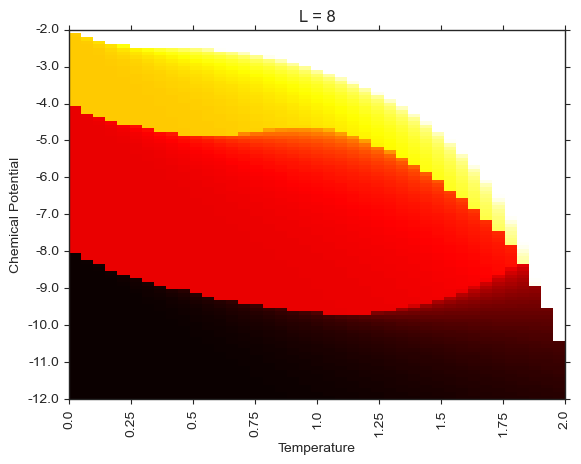

In [915]:
mu_range = [-12.0,-2.0]
mu_spacing = 0.1

T_range = [0.02,2.0]
T_spacing = 0.05

l0 = 8

temps,mus,RGB_vals = plotPhaseDiagram(T_range,T_spacing,mu_range,mu_spacing,l0)

As shown above, the emergence of different phases can be seen.

I also coded a functions to show the $p_l$ values and the corresponding note length distribution at a range of values. `tempLine` does this for a range of $T$ and a constant $\mu$ and `muLine` does the reverse.

In [5]:
def tempLine(mu,l0,tempLine):
    plt.figure(figsize=(25,4),dpi=100)
    for x in range(0,5):
        plt.subplot(1,5,x+1)
        plotProbs(tempLine[x], mu, l0)
        if x == 0:
            plt.ylabel("Probability of a Beat Occurring")
    plt.figure(figsize=(25,4),dpi=100)
    for j in range(0,5):
        plt.subplot(1,5,j+1)
        plotNoteDist(tempLine[j],mu,l0,100000,lim=16,probs=False)
        if j == 0:
            plt.ylabel("Note Probability")
        
def muLine(T,l0,muLine):
    plt.figure(figsize=(24,4),dpi=100)
    for x in range(0,5):
        plt.subplot(1,5,x+1)
        plotProbs(T, muLine[x], l0)
        if x == 0:
            plt.ylabel("Probability of a Beat Occurring")
    plt.figure(figsize=(25,4),dpi=100)
    for j in range(0,5):
        plt.subplot(1,5,j+1)
        plotNoteDist(T,muLine[j],l0,100000,lim=16,probs=False)
        if j == 0:
            plt.ylabel("Note Probability")

These two functions are useful when we want to look into the charateristics of the probability distributions while using the phase diagram as a reference. Example uses shown below.

Constant $\mu$:

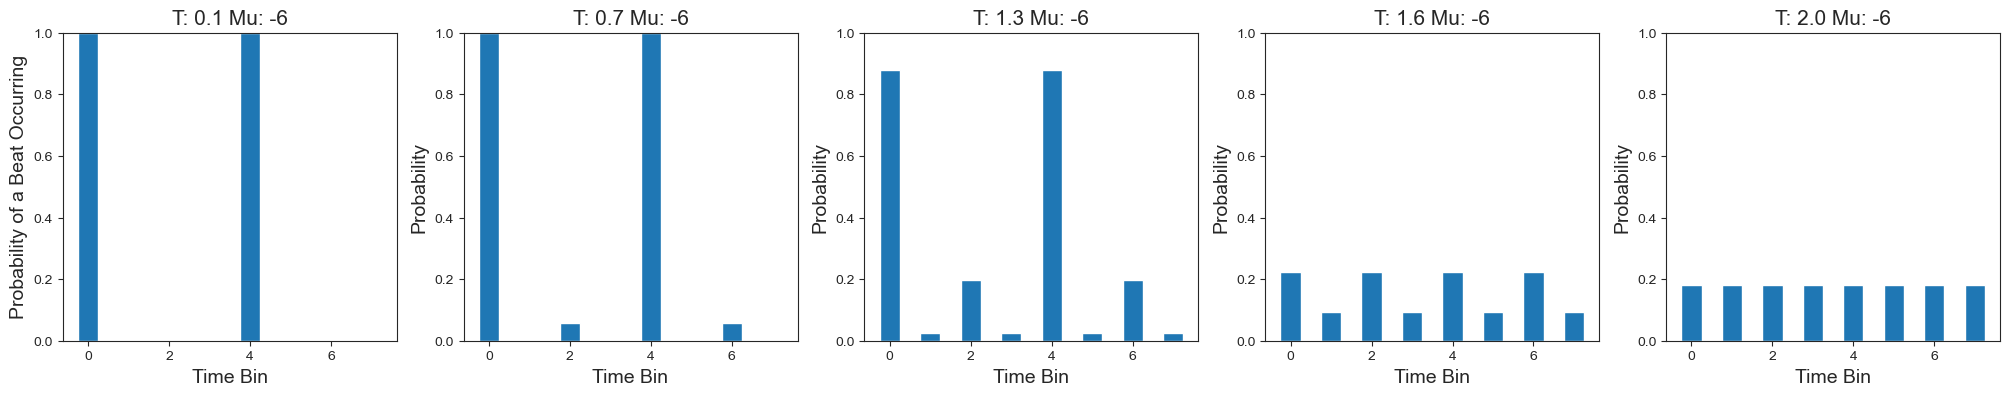

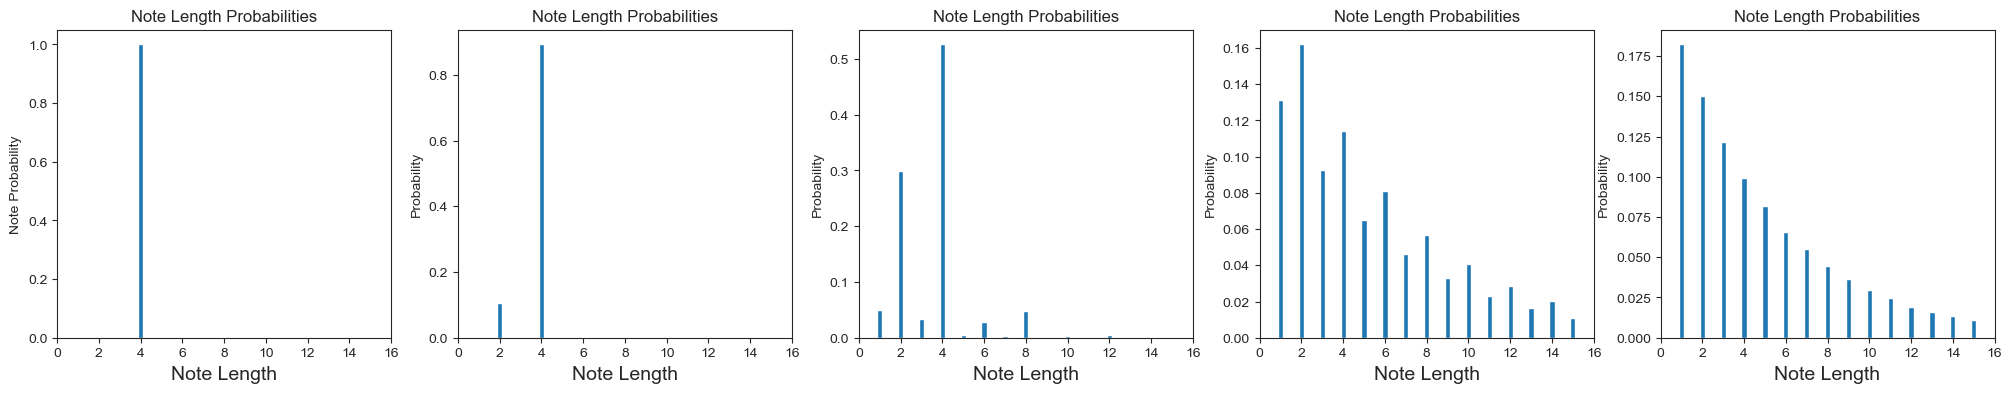

In [930]:
temp_Line = np.array([0.1,0.7,1.3,1.6,2.0])
tempLine(-6,8,temp_Line)

Constant $T$:

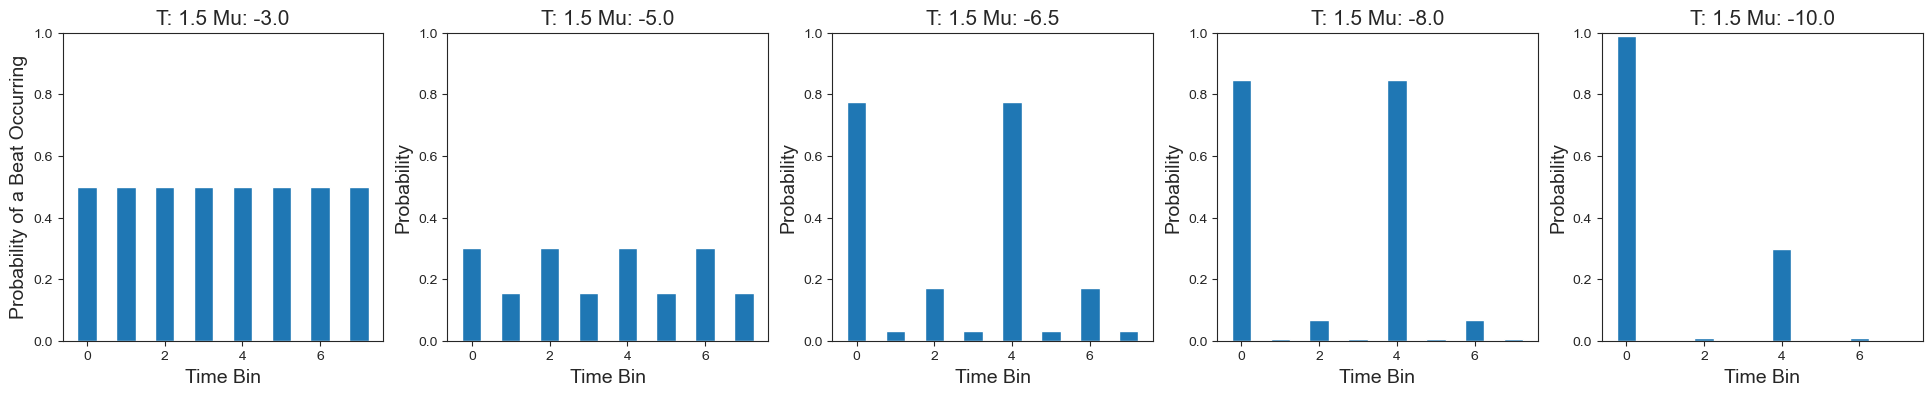

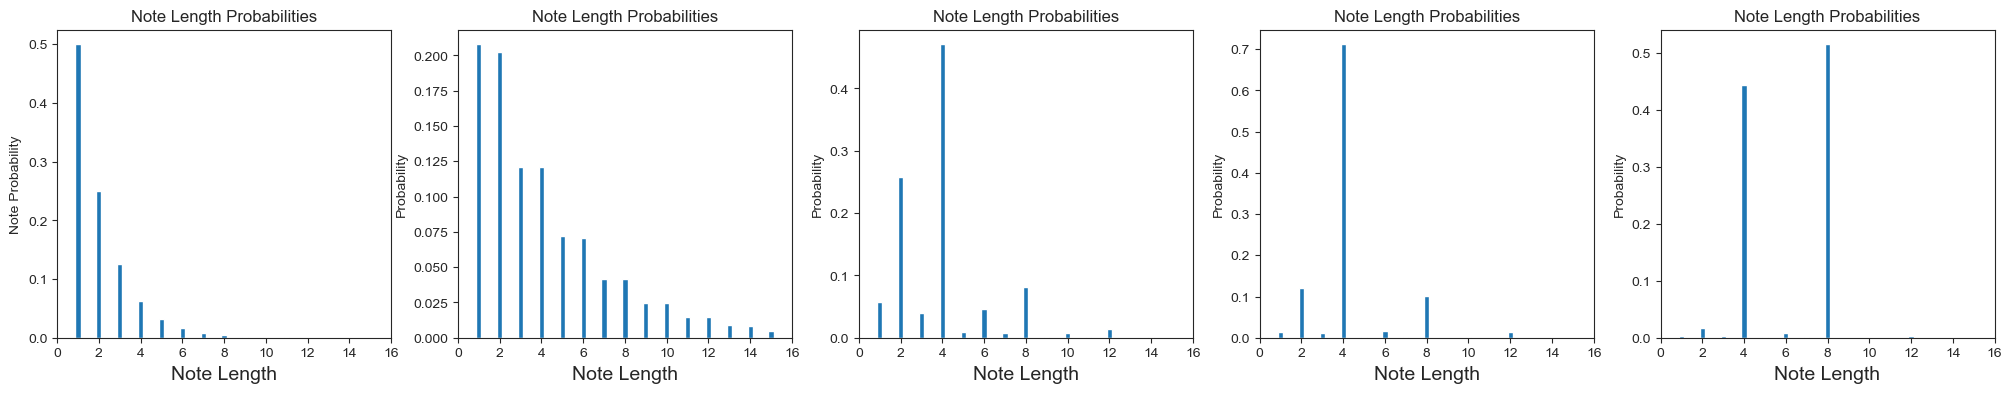

In [934]:
mu_Line = np.array([-3,-5.0,-6.5,-8.0,-10.0])
muLine(1.5,8,mu_Line)

Since the phase diagram takes a long time to generate, I saved an image of it for future use. I have three different diagrams able to be imported, one for $L=2$, one for $L=4$, and one for $L=8$. I comment out the diagrams I do not want to import. 

Below is just some code I wrote to plot a specific $T$ and $\mu$ on the phase diagram as well as display probability and note length distribution information.

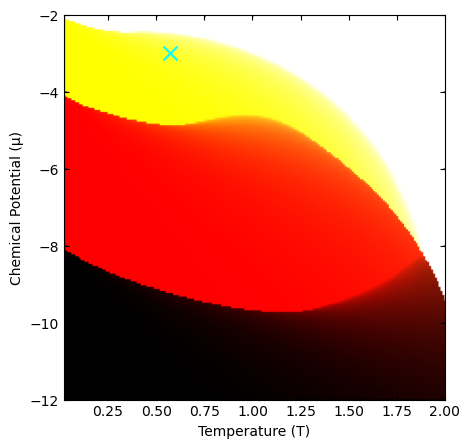

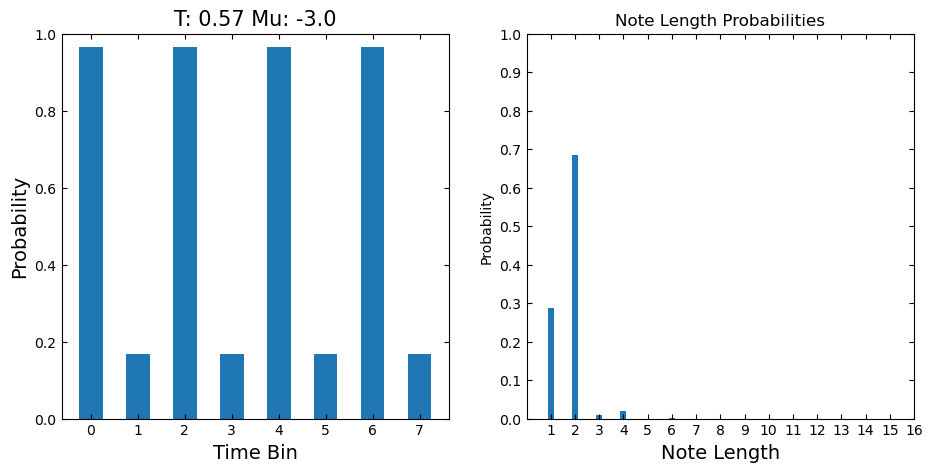

In [6]:
#im = img.imread('C:\\Users\\1600m\\Desktop\\research\\updatedModel\\2statePhase.png')[40:795,74:850]
#im = img.imread('C:\\Users\\1600m\\Desktop\\research\\updatedModel\\4statePhase-x2.png')[40:795,72:850]
im = img.imread('C:\\Users\\1600m\\Desktop\\research\\updatedModel\\8statePhase-x2.png')[40:795,85:862]

T_eval = 0.57
mu_eval = -3.0
extent = 32
l0 = 8

plt.figure(figsize=(5, 5))
plt.imshow(im,extent=(0.02,2.0,-12.0,-2.0),aspect=0.20)
plt.scatter(T_eval,mu_eval,color='cyan',marker='x',s = 100)
plt.xlabel("Temperature (T)")
plt.ylabel("Chemical Potential (µ)");

plt.figure(figsize=(11, 5))
plotNoteDist(T_eval,mu_eval,l0,100000,lim=16);
plt.xticks([1, 2, 3, 4,5,6,7,8,9,10,11,12,13,14,15,16]);
plt.yticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]);


#plt.figure(figsize=(10, 10))
#plt.imshow(im3,extent=(0.02,2.0,-12.0,-2.0),aspect=0.20)
#plt.scatter(T_eval,mu_eval,color='cyan',marker='x',s = 100)

## Obtaining Distributions of Known Compositions

I then wrote the following method to take a midi file and obtain the note length distribution from it so that I could compare it to the distributions generated by the model.

In [7]:
def plotDist(mid, minnote):
    
    if minnote < 1/16:
        scalefactor = 16*minnote
        tickrange = 1.01*scalefactor
        
    else:
        tickrange = 1.01
        scalefactor = 1.0

    tracks = mid.tracks
    tpb = mid.ticks_per_beat
    
    denom = minnote*4*tpb;

    name = np.zeros(len(tracks),dtype=object)
    f_a = np.zeros(len(tracks))
    f_b = np.zeros(len(tracks))
    note_lengths = np.zeros(len(tracks),dtype=object)

    j = 0


    for track in tracks:
        time = 0;
        downbeats = np.array([])
        notearray = np.array([])
        onArray = []
        for msg in track:
            if hasattr(msg, "note"):
                time = time + msg.time;
                if msg.velocity != 0:
                    notearray = np.append(notearray,time);
            if hasattr(msg,'name'):
                name[j] = msg.name;
        onArray = np.unique(np.round(notearray/denom));
        #print(onArray)
        note_lengths[j] = np.diff(onArray);

        j = j + 1;


    notelabels = np.zeros(int(1.0/(minnote/scalefactor))+1,dtype=object);
    for l in range(0,int(1/(minnote/scalefactor))+1):
        notelabels[l] = l

    for k in range(0,len(note_lengths)):
        if not len(note_lengths[k]) == 0:
            plt.figure(figsize=(5, 5))
            ax = plt.subplot()
            labels, counts = np.unique(note_lengths[k], return_counts=True)
            plt.bar(labels*minnote, counts/sum(counts), align='center',width = minnote/4)
            #plt.hist(note_lengths[k]*minnote,bins=24,align='mid',range=(0,0.6));
            plt.xlabel("Note Length",size=14)
            plt.ylabel("Note Probability",size=14)
            plt.xlim([0,tickrange-0.1*scalefactor])
            plt.ylim([0,1])
            plt.yticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]);
            plt.xticks(np.round(np.arange(0, tickrange, minnote),3))
            ax.set_xticklabels(notelabels)
            plt.title(name[k])

Below is the code to import the MIDIs I used for my paper. Simply run the cell of the MIDI you want to look at, or create a cell of your own with any additional MIDI fiel you choose to analyze.

In [9]:
mid = MidiFile("MIDIs and Sheet Music\\Daniel Balavoine - S.O.S. d'un Tierren en Detresse.mid")

In [11]:
mid = MidiFile("MIDIs and Sheet Music\\Finger Eleven - Paralyzer.mid")

In [16]:
mid = MidiFile("MIDIs and Sheet Music\\Lil Nas X - Industry Baby.mid")

In [17]:
mid = MidiFile("MIDIs and Sheet Music\\Miles Davis - So What (Trumpet Solo).mid")

In [100]:
mid = MidiFile("MIDIs and Sheet Music\\Pink Floyd - The Great Gig in the Sky.mid")

In [19]:
mid = MidiFile("MIDIs and Sheet Music\\The Beatles - While My Guitar Gently Weeps.mid")

In [41]:
mid = MidiFile("MIDIs and Sheet Music\\J.S. Bach - Cello Suite no. 4 (Prelude).mid")

Running the following cell will plot the note length distributions of all tracks within the MIDI. For my paper, Individual tracks were isolated from the MIDI and identified in an external editor, such as the MuseScore client. 

The value of `minnote` should be varied so that there is no pattern of gaps between peaks.

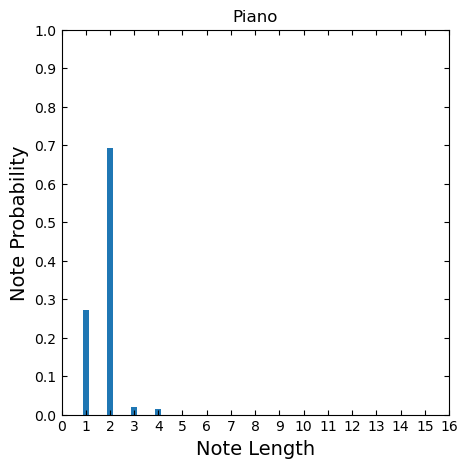

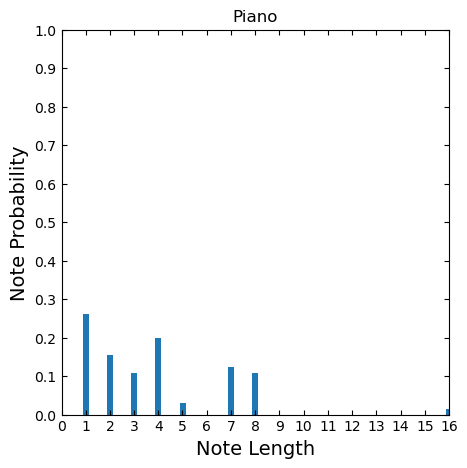

In [101]:
minnote = 1/16
plotDist(mid,minnote);

## Additional Functions

For the purpose of demonstrations, I also coded methods that will take a probability distribution generated by `plotProbs` and create an example rhythm generated by the underlying distribution. This way, I could also demonstrate what rhythmic structure can sound like at different phases. I have also allowed for the pitch of notes to change and have hard coded some scales to be used in generation. It is important to note that these pitches are not in any way generated by the statistical mechanics pitch and harmony models, however that is a direction of exploration. For the time being, the pitches are selected from the scales with equal probability.

In [24]:
def midiout(p,length,time,notevec,name):
    beatarray = np.tile(p,length)
    random = np.random.rand(len(p)*length)
    sample_vec = np.zeros(len(p)*length)
    for i in range(len(beatarray)):
        if random[i] < beatarray[i]:
            sample_vec[i] = 1;
                
    mid = MidiFile()
    track = MidiTrack()
    mid.tracks.append(track)
    track.append(Message('program_change', program=36, time=0))
    deltat = 0;
    randnote = choice(notevec)
    track.append(Message('note_on', note=randnote, velocity=64, time=deltat))
    
    for value in sample_vec:
        if value == 1:
            track.append(Message('note_on', note=randnote, velocity=0, time=deltat))
            randnote = choice(notevec)
            track.append(Message('note_on', note=randnote, velocity=64, time=deltat))
            deltat = time;
        else:
            deltat = deltat + time;
    
    mid.save(name)
    
def play_music(midi_filename):

    clock = pygame.time.Clock()
    pygame.mixer.music.load(midi_filename)
    pygame.mixer.music.play()
    while pygame.mixer.music.get_busy():
        clock.tick(30) # check if playback has finished
    
def setScale(scale,lowOct = 1,highOct = 9):
    
    outputscale = scale.copy()
    for i in range(7):
        outputscale[i] = outputscale[i] + 12*lowOct

    for x in range(1,highOct+1-lowOct):
        for y in range(7):
            outputscale.append(outputscale[y]+12*x)
    return outputscale

Cmaj = [12,14,16,17,19,21,23]
Dmaj = [2,4,6,8,9,11,13]
Emaj = [4,6,8,9,11,13,15]
Fmaj = [5,7,9,10,12,14,16]
Gmaj = [7,9,11,12,14,16,17]
Amaj = [9,11,13,14,16,18,20]
Bmaj = [11,13,15,16,18,20,22]
Csmaj = [1,3,5,6,8,10,12]
Ebmaj = [3,5,7,8,10,12,14]
Fsmaj = [6,8,10,11,13,15,17]
Gsmaj = [8,10,12,13,15,17,19]
Asmaj = [10,12,14,15,17,19,21]

PhrygianDom = [9,10,13,14,16,17,19]
Lydian = [9,11,13,15,16,18,20]
HungarianMinor = [9,11,13,15,16,17,20]
Monotone = [5,5,5,5,5,5,5]

Below is the code to generate a MIDI rhythm from a given $T$ and $\mu$. A plot of the phase diagram and the probabilites are also shown.

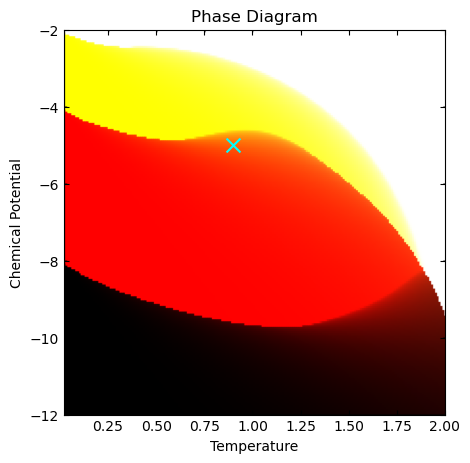

<Figure size 640x480 with 0 Axes>

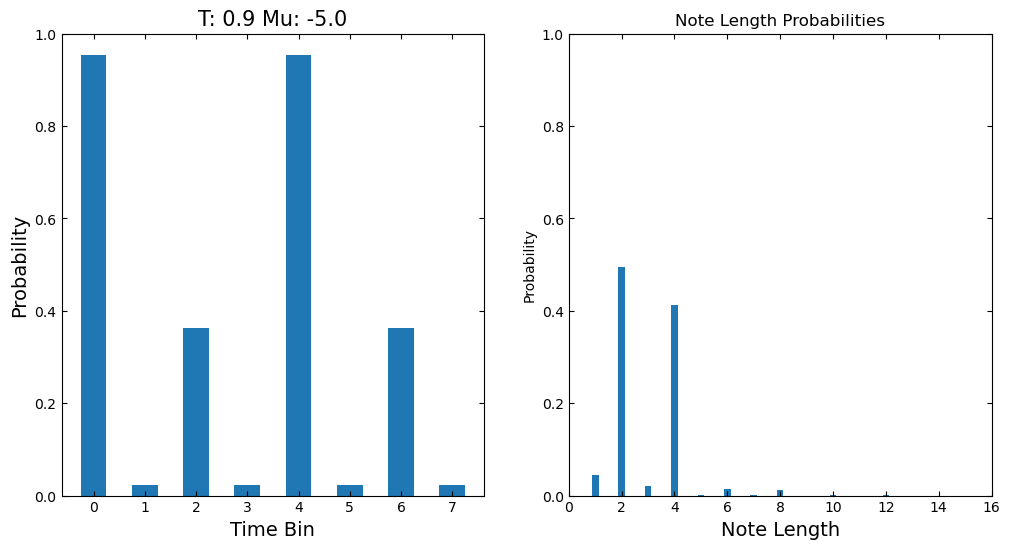

In [98]:
#Scales: Cmaj,Dmaj,Emaj,Fmaj,Gmaj,Amaj,Bmaj,Csmaj,Ebmaj,Fsmaj,Gsmaj,Asmag
#Scales: PhrygianDom,Lydian,HungrianMinor
#Input "Monotone" in setscale for a single toned rhythm.

#PARAMS
T_choice = 0.9

mu_choice = -5.0
measures = 12
spacing = 60 #(ms)
scale = setScale(Lydian,4,5)

filename = "Test.mid"


plt.figure(figsize=(5, 5))
plt.imshow(im,extent=(0.02,2.0,-12.0,-2.0),aspect=0.20)
plt.scatter(T_choice,mu_choice,color='cyan',marker='x',s = 100);
plt.title("Phase Diagram")
plt.xlabel("Temperature")
plt.ylabel("Chemical Potential")
plt.figure();


plt.figure(figsize=(12,6));
plotNoteDist(T_choice,mu_choice,8,10000,lim=16);

p1, R = plotProbs(T_choice, mu_choice, 8, display=False);
midiout(p1,measures,spacing,scale,filename);

Run this cell to play the generated rhythm:

In [99]:
# mixer config
freq = 44100  # audio CD quality
bitsize = -16   # unsigned 16 bit
channels = 2  # 1 is mono, 2 is stereo
buffer = 1024   # number of samples
pygame.mixer.init(freq, bitsize, channels, buffer)

# optional volume 0 to 1.0
pygame.mixer.music.set_volume(1.0)

play_music(filename)